In [1]:
import pandas as pd
from random import sample

from Broker import get_pnl
from uti import DataLoader, Logger
from Model.settings import DataCleaner

from Backtest import backtest_engine, plot_matrix, visual
from Backtest.settings import get_expectancy
from Model.rules import benchmark_filter, region_case_study
from library import Dataset
from Model.LR import LR
from Model.benchmark import REGION_MAPPING_DICT, MARKET_MAPPING_DICT

logger = Logger()
DL = DataLoader()
DATABASE_PATH = DL.database_path
DC = DataCleaner()
Engine = backtest_engine()

Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0
Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0
Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0


In [2]:
import numpy as np
import pandas as pd
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations, combinations, product

In [9]:
"""all_data = DL.loadDB('tpc_df_combined.csv', parse_dates=['Date', 'Time'])
all_data = all_data.sort_values('Date', ascending=True)
all_data['TPS'] = all_data.groupby(['Ticker'])['TPS_new'].apply(lambda x: x.fillna(method='ffill'))
all_data['TPS_prev'] = all_data.groupby(['Ticker'])['TPS'].apply(lambda x: x.shift(1))


train_data = all_data.iloc[:int(len(all_data) * 0.75)].copy()
test_data = all_data.iloc[int(len(all_data) * 0.75):].copy()
"""

"""DL.toDB(train_data, 'Backtest/Benchmark data/train.csv')
DL.toDB(test_data, 'Backtest/Benchmark data/test.csv')"""

"DL.toDB(train_data, 'Backtest/Benchmark data/train.csv')\nDL.toDB(test_data, 'Backtest/Benchmark data/test.csv')"

## Preprocessing

In [3]:
# train_data, test_data = DC.get_benchmark_test_data()
train_data = DL.loadDB('Backtest/Benchmark data/train.csv', parse_dates=['Date', 'Time'])
test_data = DL.loadDB('Backtest/Benchmark data/test.csv', parse_dates=['Date', 'Time'])
"""
train_data['pm_region']  = train_data['exch_location'].map(MARKET_MAPPING_DICT).fillna('Europe')
test_data['pm_region']  = test_data['exch_location'].map(MARKET_MAPPING_DICT).fillna('Europe')

train_data = train_data[~train_data['d0_date'].isna()]
test_data = test_data[~test_data['d0_date'].isna()]

train_data['delta_r'] = (train_data['d0_close'] - train_data['d0_open']) / train_data['atr_used']
test_data['delta_r'] = (test_data['d0_close'] - test_data['d0_open']) / test_data['atr_used']

train_data['exch_region2'] = train_data['exch_region']
test_data['exch_region2'] = test_data['exch_region']

train_data['exch_location'] = train_data['exch_location'].replace(MARKET_MAPPING_DICT)
test_data['exch_location'] = test_data['exch_location'].replace(MARKET_MAPPING_DICT)

train_data['exch_region'] = train_data['exch_location'].replace(REGION_MAPPING_DICT)
test_data['exch_region'] = test_data['exch_location'].replace(REGION_MAPPING_DICT)

train_data.loc[train_data['exch_region2']=='Europe', 'exch_region'] = 'Europe'
test_data.loc[test_data['exch_region2']=='Europe', 'exch_region'] = 'Europe'

#train_data['Sector'] = train_data['Sector'].fillna('').apply(lambda x: x.split(',')[0])
#test_data['Sector'] = test_data['Sector'].fillna('').apply(lambda x: x.split(',')[0])"""

11:49:03 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Log/20220422/20220422114903.txt created.
11:49:03 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/Benchmark data/train.csv
11:49:04 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/Benchmark data/test.csv


"\ntrain_data['pm_region']  = train_data['exch_location'].map(MARKET_MAPPING_DICT).fillna('Europe')\ntest_data['pm_region']  = test_data['exch_location'].map(MARKET_MAPPING_DICT).fillna('Europe')\n\ntrain_data = train_data[~train_data['d0_date'].isna()]\ntest_data = test_data[~test_data['d0_date'].isna()]\n\ntrain_data['delta_r'] = (train_data['d0_close'] - train_data['d0_open']) / train_data['atr_used']\ntest_data['delta_r'] = (test_data['d0_close'] - test_data['d0_open']) / test_data['atr_used']\n\ntrain_data['exch_region2'] = train_data['exch_region']\ntest_data['exch_region2'] = test_data['exch_region']\n\ntrain_data['exch_location'] = train_data['exch_location'].replace(MARKET_MAPPING_DICT)\ntest_data['exch_location'] = test_data['exch_location'].replace(MARKET_MAPPING_DICT)\n\ntrain_data['exch_region'] = train_data['exch_location'].replace(REGION_MAPPING_DICT)\ntest_data['exch_region'] = test_data['exch_location'].replace(REGION_MAPPING_DICT)\n\ntrain_data.loc[train_data['exch_re

In [4]:
train_data['pm_region'].value_counts()

Americas              25332
Europe                 9824
Korea & Japan          4295
Southeast Asia         1686
Taiwan & Singapore     1372
Hong Kong              1145
South Africa            760
China                   182
Turkey                    6
Name: pm_region, dtype: int64

In [5]:
# if 'market_cap_usd' in train_data.columns:
bins_mc = [-np.inf, 5e+7, 3e+8, 2e+9, 1e+10, 2e+11, np.inf]
mc_labels = ['NanoCap', 'MicroCap', 'SmallCap', 'MidCap', 'LargeCap', 'MegaCap']
train_data['market_cap_grp'] = pd.cut(x=train_data['market_cap_usd'], bins=bins_mc, include_lowest=True, labels=mc_labels)
test_data['market_cap_grp'] = pd.cut(x=test_data['market_cap_usd'], bins=bins_mc, include_lowest=True, labels=mc_labels)

In [4]:
def benchmark_rule(df_):
    if 'side' not in df_.columns:
        df_['side'] = 'neutral'
    df = df_[['Headline sentiment', 'Summary sentiment', 'side']].copy()
    
#     long_mask = ((df['Headline sentiment'] == 'positive') & (df['Summary sentiment'] != 'negative')) | ((df['Summary sentiment'] == 'positive') & (df['Headline sentiment'] != 'negative'))
    long_mask = ((df['Headline sentiment'] == 'positive') & (df['Summary sentiment'] == 'positive'))
    short_mask = (df['Headline sentiment'] == 'negative') | (df['Summary sentiment'] == 'negative')
    
    df['side'] = np.where(long_mask, 'long', df['side'])
    df['side'] = np.where(short_mask, 'short', df['side'])
    
    return df['side']

def benchmark_rule2(df_):
    if 'side' not in df_.columns:
        df_['side'] = 'neutral'
    df = df_[['TPS', 'TPS_prev', 'RC_upgrade', 'RC_downgrade', 'side']].copy()

    long_mask = (df['TPS_prev'] < df['TPS'])
    short_mask = (df['TPS_prev'] > df['TPS'])

    df['side'] = np.where(long_mask, 'long',df['side'])
    df['side'] = np.where(short_mask, 'short', df['side'])

    return df['side']


def benchmark_rule3(df_):
    if 'side' not in df_.columns:
        df_['side'] = 'neutral'
    df = df_[['RC_upgrade', 'RC_downgrade', 'side']].copy()

    long_mask = ((df['RC_upgrade'] == 'Y') & (df['RC_downgrade'] != 'Y'))
    short_mask = ((df['RC_upgrade'] != 'Y') & (df['RC_downgrade'] == 'Y'))

    df['side'] = np.where(long_mask, 'long', df['side'])
    df['side'] = np.where(short_mask, 'short', df['side'])

    return df['side']

def benchmark_rule4(df_):
    if 'side' not in df_.columns:
        df_['side'] = 'neutral'
    



In [7]:
train_data['side'] = benchmark_rule(train_data)
test_data['side'] = benchmark_rule(test_data)

train_data['side'] = benchmark_rule2(train_data)
test_data['side'] = benchmark_rule2(test_data)

train_data['side'] = benchmark_rule3(train_data)
test_data['side'] = benchmark_rule3(test_data)

train_data = get_pnl(train_data)
test_data = get_pnl(test_data)

10:59:51 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Log/20220422/20220422105918.txt created.
10:59:51 Calculating pnl...
10:59:51 Row 0 BVTJ.J completed.
10:59:52 Row 1000 ACN completed.
10:59:52 Position: [<FrameSummary file C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\Broker\pnl.py, line 164 in get_pnl>, <FrameSummary file C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\uti\logger.py, line 41 in info>] | Error type: <class 'PermissionError'> | Error: [Errno 13] Permission denied: 'C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\\Database/Log/20220422/20220422105918.txt'
10:59:52 Row 1000 ACN error
10:59:52 Position: [<FrameSummary file C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\Broker\pnl.py, line 164 in get_pnl>, <FrameSummary file C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\uti\logger.py, line 41 in info>] | Error type: <class 'PermissionError'> | Error: [Errno 13] Permission denied: 'C:/Users/JayYang

In [10]:
DL.toDB(train_data, 'Backtest/Benchmark data/train.csv')
DL.toDB(test_data, 'Backtest/Benchmark data/test.csv')

In [9]:
train_data

,Date,Time,Ticker,Tickers,company,Headline,Summary,Region,Industry,Head analyst,...,RC_downgrade,pm_region,delta_r,exch_region2,market_cap_grp,side,stop_loss,d0_r,d1_r,d2_r
0,2017-03-01,2017-03-01 13:05:00,BVTJ.J,BVTJ.J,Bidvest,"Bidvest (BVTJ.J): Near-term pain, but we see s...",Closer inspection of Bidvest's interim results...,SJ,Industrial Conglomerates,Kgosietsile S Rahube,...,NaN,South Africa,0.143850,Africa,MidCap,short,16813.494639,-0.143850,-1.000000,-1.000000
1,2017-03-01,2017-03-01 15:01:00,VODJ.J,VODJ.J,Vodacom Group Limited,Alert: Vodacom Group Limited (VODJ.J) - Tanzan...,Regulator approves offer of 25% of Vodacom Tan...,SJ,Wireless Telecommunication Services,"Michael R Gresty, CFA",...,NaN,South Africa,-1.150161,Africa,LargeCap,neutral,0.000000,0.000000,0.000000,0.000000
2,2017-03-02,2017-03-02 21:34:00,EXXJ.J,EXXJ.J,Exxaro Resources Limited,Exxaro Resources Limited (EXXJ.J): Implied val...,Implied value analysis - Given that Exxaro sha...,SJ,Coal & Consumable Fuels,Heath R Jansen,...,NaN,South Africa,-0.106669,Africa,MidCap,neutral,0.000000,0.000000,0.000000,0.000000
3,2017-03-02,2017-03-02 12:00:00,NEDJ.J,NEDJ.J,Nedbank,Nedbank (NEDJ.J): Set for double-digit growth ...,We view the FY16 result as a strong underlying...,SJ,Diversified Banks,Simon Nellis,...,NaN,South Africa,0.152405,Africa,MidCap,long,24345.431207,0.152405,1.244419,0.927682
4,2017-03-02,2017-03-02 15:36:00,SBKJ.J,SBKJ.J,Standard Bank,Results: Standard Bank (SBKJ.J) - FY16 &ndash;...,Citi's Take - Standard Bank reported diluted H...,SJ,Diversified Banks,Simon Nellis,...,NaN,South Africa,2.035890,Africa,LargeCap,long,14484.066585,2.035890,2.459464,2.732738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44597,2021-07-06,2021-07-06 17:28:00,PURP.L,PURP.L,Purplebricks Group Plc,Purplebricks Group Plc (PURP.L): FY21 Results...,Today's FY21 results should provide investors ...,LN,Interactive Media & Services,Ross Jobber,...,NaN,Europe,-1.007255,Europe,SmallCap,long,81.632413,-1.000000,-1.000000,-1.000000
44598,2021-07-06,2021-07-06 14:24:00,SAEG.DE,SAEG.DE,Shop Apotheke Europe,Shop Apotheke Europe (SAEG.DE): Q2 Sales +7.3%...,Shop Apotheke posted a weak trading update thi...,GY,Internet & Direct Marketing Retail,Ajay Nandal,...,NaN,Europe,-1.100912,Europe,MidCap,short,154.420869,1.100912,1.839171,1.774412
44599,2021-07-06,2021-07-06 16:52:00,SCMA.JK,SCMA.JK,Surya Citra Media,Surya Citra Media (SCMA.JK): Netflix to invest...,Local online media Katadata's D-Insights platf...,IJ,Broadcasting,Justian Rama,...,NaN,Southeast Asia,0.682667,Asia,MidCap,neutral,0.000000,0.000000,0.000000,0.000000
44600,2021-07-06,2021-07-06 14:11:00,7201.T,7201.T,Nissan Motor,Nissan Motor (7201.T): Maintaining Neutral but...,The shares have picked back up after the disap...,JP,Automobile Manufacturers,Arifumi Yoshida,...,NaN,Korea & Japan,0.364976,Asia,LargeCap,long,562.508552,0.364976,0.012585,-1.000000


In [5]:
def get_expectancy(_df, group_by=[]):
    # Given a dataset of trades, groupby based a given set of criteria, and output the expectancy of each group.
    df = _df[~_df['side'].isin(['neutral'])].copy()
    column = 'd0_r'
    inputs = ['No. of trades', column]
    inputs.extend(group_by)
    df.loc[:, 'No. of trades'] = 1  # maybe unnecessary
    if len(group_by) > 0:
        expectancy = df[inputs].groupby(group_by)[column].agg({
            ('Hit ratio', lambda x: (x > 0).sum() / len(x)),
            ('Loss ratio', lambda x: (x < 0).sum() / len(x)),
            ('Avg win size', lambda x: x[x > 0].mean()),
            ('Avg losing size', lambda x: x[x < 0].mean()),
            ('Count', 'count')}).fillna(0)
    else:
        expectancy = df[column].agg({
            'Hit ratio': lambda x: (x > 0).sum() / len(x) if len(x) > 0 else 0,
            'Loss ratio': lambda x: (x < 0).sum() / len(x) if len(x) > 0 else 0,
            'Avg win size': lambda x: x[x > 0].mean(),
            'Avg losing size': lambda x: x[x < 0].mean(),
            'No. of trades': lambda x: x.sum()})
    # print(expectancy)
    try:
        expectancy['Expectancy'] = expectancy['Hit ratio'] * expectancy['Avg win size'] + \
                                   expectancy['Loss ratio'] * expectancy['Avg losing size']
    except:
        print(expectancy)
        print()
    return expectancy

In [6]:
def sub_ele_index(ele, row):
    result = []
    for sub_ele in ele:
        result.append(row[sub_ele])
    return tuple(result)

def get_daily_trade(_train_data, _test_data, score_weights = [], intercept=[0]):
#     exclusion_list = ['Australia', 'Turkey', 'Czech Republic', 'Poland', 'Greece', 'Americas']
    exclusion_list = []
    training_data = _train_data[~_train_data['exch_location'].isin(exclusion_list)].reset_index(drop=True).copy()
    testing_data = _test_data[~_test_data['exch_location'].isin(exclusion_list)].reset_index(drop=True).copy()
    
    all_data = pd.concat([training_data, testing_data], axis=0).copy()

    elements = [
#                 ['Ticker'], # Ticker + Head analyst
        # Head senti + Sum senti
        # Upgrade long, downgrade short, common sense way
        # AH, Earnings, sentiment only 
        # Rules regardless of senti, consistent bias.
                ['Head analyst'],
                ['Ticker'],
                ['release_period'],
                ['Report Type'],
                ]
    elements_name = []
    
    if len(score_weights) == 0:
        score_weights = [0.2] * len(elements)
    for ele in elements:
        expectancy = get_expectancy(training_data, group_by=ele)

        unique_values = []
        if len(ele) > 1:
            for sub_ele in ele:
                unique_values.append(all_data[sub_ele].unique())
            combinations = product(*unique_values)
            
        else:
            combinations = all_data[ele[0]].unique()
            
        case_unfound = set(combinations).difference(set(expectancy.index))
        case_unfound_df = pd.DataFrame(0, index=case_unfound, columns=expectancy.columns)
        expectancy = pd.concat([expectancy, case_unfound_df], axis=0)
        
        # print(expectancy)
        
        
        if len(ele) > 1:
            ele_name = '_'.join(ele)+'_score'
            
        else:
            ele_name = ele[0] + '_score'
            # training_data[f'{ele_name}'] = training_data[ele[0]].map(dict(expectancy['Expectancy'])).fillna(0)
            # testing_data[f'{ele_name}'] = testing_data[ele[0]].map(dict(expectancy['Expectancy'])).fillna(0)
        training_data[f'{ele_name}'] = [expectancy.loc[sub_ele_index(ele, row)]['Expectancy'] for _, row in training_data[ele].iterrows()]
        testing_data[f'{ele_name}'] = [expectancy.loc[sub_ele_index(ele, row)]['Expectancy'] for _, row in testing_data[ele].iterrows()]
        print(ele_name)
        elements_name.append(ele_name)
        print(elements_name)
        
    training_data['score'] = np.sum(score_weights * training_data[elements_name],axis=1) + intercept[0]
    testing_data['score'] = np.sum(score_weights * testing_data[elements_name],axis=1) + intercept[0]
    
#     test_data.loc[test_data['score'] < 0, 'side'] = ''
#     test_data.loc[test_data['score'] < 0, 'score'] = 0
    
    return training_data, testing_data, elements_name


train_data, test_data, elements_name = get_daily_trade(train_data, test_data)

Head analyst_score
['Head analyst_score']
Ticker_score
['Head analyst_score', 'Ticker_score']
release_period_score
['Head analyst_score', 'Ticker_score', 'release_period_score']
Report Type_score
['Head analyst_score', 'Ticker_score', 'release_period_score', 'Report Type_score']


In [7]:
model = LR(train_data[elements_name], train_data[['d0_r']])
model.train()
model.evaluate()
# intercept = -0.03506858
# ols_weights = [0.86667071, 0.03735833, 0.16950042]
intercept, ols_weights = model.get_params()

# test_data['score'] = np.sum(ols_weights * test_data[elements_name],axis=1) + intercept[0]

Intercept: [-0.05483611]
Coefficients: [[0.15857009 0.58927224 0.40785076 0.26123222]]
Score:  0.06061693352155162
R2 score:  0.06061693352155162
MSE score:  0.4903317838903733
RMSE score:  0.7002369483898813
                            OLS Regression Results                            
Dep. Variable:                   d0_r   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     719.4
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:50:11   Log-Likelihood:                -47394.
No. Observations:               44602   AIC:                         9.480e+04
Df Residuals:                   44597   BIC:                         9.484e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
 

C:\Users\JayYang\Anaconda3\envs\Goldman\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
strategy = 'scoring (PM) train'

pnl_df = train_data.copy()

lasso = Lasso(alpha=1e-3)
lasso.fit(pnl_df[elements_name], pnl_df['d0_r'])
print(lasso.coef_)
print(lasso.intercept_)

prediction = lasso.predict(pnl_df[elements_name])
r2 = r2_score(pnl_df['d0_r'], prediction)
mse = mean_squared_error(pnl_df['d0_r'], prediction)
rmse = np.sqrt(mse)

print('Score: ', lasso.score(pnl_df[elements_name], pnl_df['d0_r']))
print('R2 score: ', r2)
print('MSE score: ', mse)
print('RMSE score: ', rmse)


pnl_df['score'] =  np.sum(lasso.coef_ * pnl_df[elements_name],axis=1) + lasso.intercept_
# pnl_df = pnl_df[pnl_df['score']>0].reset_index(drop=True)
pnl_df = Engine.portfolio_management(pnl_df, rank_by='score')
DL.toBT(pnl_df, strategy)
vis2 = visual(strategy)
vis2.visual_job()

## Ridge Regression

In [75]:
from sklearn.linear_model import Ridge, Lasso

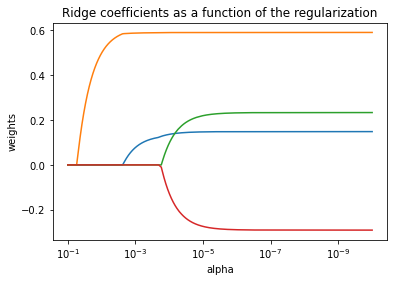

In [78]:
n_alphas = 2000
alphas = np.logspace(-10, -1, n_alphas)

clf = Lasso(fit_intercept=False)
coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(train_data[elements_name], train_data['d0_r'])
    coefs.append(clf.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
#将alpha的值取对数便于画图
ax.set_xscale('log')
#翻转x轴的大小方向，让alpha从大到小显示
ax.set_xlim(ax.get_xlim()[::-1]) 

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Train data

In [9]:
strategy = 'train_data_scoring_ols'
train_data['score'] = np.sum(ols_weights * train_data[elements_name],axis=1) + intercept[0]
pnl_df = Engine.portfolio_management(train_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)


11:16:31 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Log/20220422/20220422111443.txt created.
11:16:31 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_ols.csv
side 
long     3317
short    3298
dtype: int64
 Sum of d0_r 1366.1909119672805
 Sum of d1_r 1653.3478219015285
 Sum of d2_r 1702.8790353363802
Americas Sum of d0_r 632.5993742490696
Americas Sum of d1_r 729.7740211522164
Americas Sum of d2_r 725.1825430855909
Asia Sum of d0_r 304.449847431216
Asia Sum of d1_r 399.91896676233625
Asia Sum of d2_r 430.23423153423664
Europe Sum of d0_r 417.8562884963732
Europe Sum of d1_r 505.05159369033385
Europe Sum of d2_r 530.9064057094832
South Africa Sum of d0_r 11.285401790621703
South Africa Sum of d1_r 18.603240296641957
South Africa Sum of d2_r 16.555855007069365
Long trades hit ratio 0.5529
Short trades hit ratio 0.5846
Hit ratio             0.568707
Loss ratio            0.418594
Avg win size          0.785166
Avg losin

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Hit ratio  Loss ratio  Count  Avg win size  \
exch_location                                                    
Americas             0.552585    0.442068   3366      0.801061   
Australia            1.000000    0.000000      1      0.353563   
Austria              0.555556    0.333333      9      0.654115   
Belgium              0.680000    0.320000     50      0.922080   
Czech Republic       1.000000    0.000000      1      0.119922   
Denmark              0.590000    0.410000    100      0.940772   
Finland              0.448276    0.517241     29      0.932723   
France               0.633721    0.343023    172      0.975698   
Germany              0.536122    0.448669    263      0.884547   
Hong Kong            0.669065    0.309353    139      0.840847   
Italy                0.641975    0.358025     81      0.773415   
Korea & Japan        0.571823    0.406077    724      0.694027   
Netherlands          0.574074    0.425926    108      0.833297   
Norway    

posx and posy should be finite values
posx and posy should be finite values


              Hit ratio  Avg win size  Count  Loss ratio  Avg losing size
exch_region                                                              
Americas       0.552585      0.801061   3366    0.442068        -0.576192
Asia           0.596950      0.720641   1377    0.371097        -0.563438
Europe         0.575890      0.807718   1825    0.412055        -0.573213
South Africa   0.617021      0.777309     47    0.382979        -0.625365
                    Avg losing size  Avg win size  Count  Hit ratio  \
exch_region  side                                                     
Americas     long         -0.614137      0.818414   1683   0.541889   
             short        -0.536258      0.784366   1683   0.563280   
Asia         long         -0.572306      0.739295    698   0.578797   
             short        -0.553346      0.702611    679   0.615611   
Europe       long         -0.590207      0.840530    913   0.549836   
             short        -0.553589      0.777716    912   

In [3]:
strategy = 'train_data_scoring_ols'
vis = visual(strategy)
vis.visual_job()

11:58:13 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Log/20220422/20220422115746.txt created.
11:58:13 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_ols.csv


C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\Backtest\visualize.py:17: DtypeWarning: Columns (56,57) have mixed types.Specify dtype option on import or set low_memory=False.
  self.trades_df = DL.loadDB(f'Backtest/{strategy}.csv', parse_dates=['Date', 'd0_date'])


side 
long     4116
short    4116
dtype: int64
 Sum of d0_r 1826.4664112407931
 Sum of d1_r 2091.069003817442
 Sum of d2_r 2195.3021011226106
Americas Sum of d0_r 904.483429841892
Americas Sum of d1_r 1012.405879270897
Americas Sum of d2_r 1051.7841315212477
Asia Sum of d0_r 461.5929045598258
Asia Sum of d1_r 505.9277762411555
Asia Sum of d2_r 538.0214386353585
Europe Sum of d0_r 449.2063736927157
Europe Sum of d1_r 553.2794356340103
Europe Sum of d2_r 587.3620071621338
South Africa Sum of d0_r 11.183703146359726
South Africa Sum of d1_r 19.45591267137973
South Africa Sum of d2_r 18.13452380387039
Americas Sum of d0_r 904.483429841892
Americas Sum of d1_r 1012.405879270897
Americas Sum of d2_r 1051.7841315212477
China Sum of d0_r 8.079144449716456
China Sum of d1_r 6.907256350675737
China Sum of d2_r 6.341804440628382
Europe Sum of d0_r 449.6444069408938
Europe Sum of d1_r 554.0735281254797
Europe Sum of d2_r 586.7843594294347
Hong Kong Sum of d0_r 95.09589803115529
Hong Kong Sum of d1

posx and posy should be finite values
posx and posy should be finite values


                    Hit ratio  Avg win size  Avg losing size  Loss ratio  \
exch_location                                                              
Americas             0.557109      0.848582        -0.588840    0.438863   
Australia            1.000000      0.219017         0.000000    0.000000   
Austria              0.625000      0.709276        -0.559072    0.250000   
Belgium              0.666667      0.793614        -0.483755    0.333333   
China                0.673913      0.514585        -0.562357    0.304348   
Czech Republic       1.000000      0.119922         0.000000    0.000000   
Denmark              0.576087      0.913316        -0.619324    0.423913   
Finland              0.454545      0.977897        -0.696732    0.515152   
France               0.586538      0.967571        -0.531795    0.394231   
Germany              0.516529      0.823720        -0.614943    0.471074   
Hong Kong            0.623134      0.870176        -0.540038    0.347015   
Italy       

C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\Backtest\settings.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 9))
posx and posy should be finite values


              Avg win size  Hit ratio  Avg losing size  Loss ratio  Count
exch_region                                                              
Americas          0.848582   0.557109        -0.588840    0.438863   4220
Asia              0.716623   0.599112        -0.549133    0.367357   2028
Europe            0.825837   0.569887        -0.572573    0.418808   1946
South Africa      0.845229   0.605263        -0.550438    0.394737     38
                    Hit ratio  Avg win size  Avg losing size  Loss ratio  \
exch_region  side                                                          
Americas     long    0.541706      0.845934        -0.616726    0.455450   
             short   0.572512      0.851087        -0.558763    0.422275   
Asia         long    0.595661      0.767453        -0.550852    0.376726   
             short   0.602564      0.666375        -0.547324    0.357988   
Europe       long    0.539568      0.846932        -0.586294    0.452210   
             short   0.6

In [8]:
strategy = 'train_data_scoring_ols'
train_data['score'] = np.sum(ols_weights * train_data[elements_name],axis=1) + intercept[0]
pnl_df = Engine.portfolio_management(train_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:50:16 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Log/20220422/20220422114902.txt created.
11:50:16 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_ols.csv


C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\Backtest\visualize.py:17: DtypeWarning: Columns (56,57) have mixed types.Specify dtype option on import or set low_memory=False.
  self.trades_df = DL.loadDB(f'Backtest/{strategy}.csv', parse_dates=['Date', 'd0_date'])


side 
long     4116
short    4116
dtype: int64
 Sum of d0_r 1826.4664112407931
 Sum of d1_r 2091.069003817442
 Sum of d2_r 2195.3021011226106
Americas Sum of d0_r 904.483429841892
Americas Sum of d1_r 1012.405879270897
Americas Sum of d2_r 1051.7841315212477
Asia Sum of d0_r 461.5929045598258
Asia Sum of d1_r 505.9277762411555
Asia Sum of d2_r 538.0214386353585
Europe Sum of d0_r 449.2063736927157
Europe Sum of d1_r 553.2794356340103
Europe Sum of d2_r 587.3620071621338
South Africa Sum of d0_r 11.183703146359726
South Africa Sum of d1_r 19.45591267137973
South Africa Sum of d2_r 18.13452380387039
Long trades hit ratio 0.5554
Short trades hit ratio 0.5860
Hit ratio             0.570700
Loss ratio            0.416302
Avg win size          0.809069
Avg losing size      -0.576171
No. of trades      1826.466411
Name: d0_r, dtype: float64
       Hit ratio  Loss ratio  Count  Avg losing size  Avg win size
side                                                              
long    0.555394    

posx and posy should be finite values
posx and posy should be finite values


                    Hit ratio  Avg win size  Count  Avg losing size  \
exch_location                                                         
Americas             0.557109      0.848582   4220        -0.588840   
Australia            1.000000      0.219017      2         0.000000   
Austria              0.625000      0.709276     16        -0.559072   
Belgium              0.666667      0.793614     57        -0.483755   
China                0.673913      0.514585     46        -0.562357   
Czech Republic       1.000000      0.119922      1         0.000000   
Denmark              0.576087      0.913316     92        -0.619324   
Finland              0.454545      0.977897     33        -0.696732   
France               0.586538      0.967571    208        -0.531795   
Germany              0.516529      0.823720    242        -0.614943   
Hong Kong            0.623134      0.870176    268        -0.540038   
Italy                0.628205      0.807940     78        -0.609237   
Korea 

posx and posy should be finite values


              Avg win size  Count  Avg losing size  Loss ratio  Hit ratio
exch_region                                                              
Americas          0.848582   4220        -0.588840    0.438863   0.557109
Asia              0.716623   2028        -0.549133    0.367357   0.599112
Europe            0.825837   1946        -0.572573    0.418808   0.569887
South Africa      0.845229     38        -0.550438    0.394737   0.605263
                    Hit ratio  Avg win size  Count  Loss ratio  \
exch_region  side                                                
Americas     long    0.541706      0.845934   2110    0.455450   
             short   0.572512      0.851087   2110    0.422275   
Asia         long    0.595661      0.767453   1014    0.376726   
             short   0.602564      0.666375   1014    0.357988   
Europe       long    0.539568      0.846932    973    0.452210   
             short   0.600206      0.806874    973    0.385406   
South Africa long    0.73684

In [17]:
strategy = 'train_data_scoring_mean'
train_data['score'] = np.mean(train_data[elements_name],axis=1)
pnl_df = Engine.portfolio_management(train_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:06:34 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_mean.csv
side 
long     4256
short    4225
dtype: int64
 Sum of d0_r 1089.084429135355
 Sum of d1_r 1410.7719168704
 Sum of d2_r 1449.8996659058532
Americas Sum of d0_r 468.3414755496454
Americas Sum of d1_r 577.2756224208696
Americas Sum of d2_r 548.6515248884161
Asia Sum of d0_r 277.05922760744136
Asia Sum of d1_r 404.18972687645487
Asia Sum of d2_r 434.52673152712987
Europe Sum of d0_r 328.55949330705675
Europe Sum of d1_r 411.9668491284961
Europe Sum of d2_r 450.60311037038485
South Africa Sum of d0_r 15.124232671211667
South Africa Sum of d1_r 17.339718444579596
South Africa Sum of d2_r 16.118299119922472
Long trades hit ratio 0.5219
Short trades hit ratio 0.5512
Hit ratio             0.536493
Loss ratio            0.450419
Avg win size          0.717533
Avg losing size      -0.569552
No. of trades      1089.084429
Name: d0_r, dtype: float64
       Avg win size  Avg losing s

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Avg win size  Count  Avg losing size  Hit ratio  \
exch_location                                                         
Americas                0.722929   4272        -0.572078   0.524345   
Australia               0.286553      3        -0.141666   0.666667   
Austria                 0.760579     22        -0.708733   0.590909   
Belgium                 0.740735     50        -0.614263   0.660000   
Czech Republic          0.119922      1         0.000000   1.000000   
Denmark                 0.967563     91        -0.681865   0.604396   
Finland                 0.798283     32        -0.553509   0.312500   
France                  0.794205    277        -0.547496   0.541516   
Germany                 0.793524    285        -0.588865   0.557895   
Greece                  0.000000      1        -0.185721   0.000000   
Hong Kong               0.795234    243        -0.506136   0.522634   
Ireland                 1.538928      5        -1.000000   0.400000   
Italy 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


              Avg losing size  Count  Avg win size  Loss ratio  Hit ratio
exch_region                                                              
Americas            -0.572078   4272      0.722929    0.470974   0.524345
Asia                -0.556260   2010      0.675929    0.418408   0.548259
Europe              -0.573900   2113      0.747412    0.441552   0.547089
South Africa        -0.629595     86      0.702509    0.395349   0.604651
                    Hit ratio  Loss ratio  Avg losing size  Avg win size  \
exch_region  side                                                          
Americas     long    0.513577    0.483146        -0.600293      0.754492   
             short   0.535112    0.458801        -0.542366      0.692637   
Asia         long    0.525025    0.442591        -0.550751      0.708576   
             short   0.572149    0.393542        -0.562632      0.645125   
Europe       long    0.528355    0.463138        -0.592009      0.783796   
             short   0.5

In [9]:
strategy = 'train_data_scoring_mean'
train_data['score'] = np.mean(train_data[elements_name],axis=1)
pnl_df = Engine.portfolio_management(train_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:50:25 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_mean.csv
side 
long     5311
short    5311
dtype: int64
 Sum of d0_r 1401.0460240833988
 Sum of d1_r 1686.6713595429335
 Sum of d2_r 1741.182195192158
Americas Sum of d0_r 649.7352257240278
Americas Sum of d1_r 745.5575420472059
Americas Sum of d2_r 721.3027906421446
Asia Sum of d0_r 359.0551256202482
Asia Sum of d1_r 451.5362359495804
Asia Sum of d2_r 490.9884585738115
Europe Sum of d0_r 377.28359259057356
Europe Sum of d1_r 471.69633879518585
Europe Sum of d2_r 510.71444744454755
South Africa Sum of d0_r 14.972080148549395
South Africa Sum of d1_r 17.881242750961732
South Africa Sum of d2_r 18.176498531654296
Long trades hit ratio 0.5210
Short trades hit ratio 0.5411
Hit ratio             0.531068
Loss ratio            0.455470
Avg win size          0.746386
Avg losing size      -0.580678
No. of trades      1401.046024
Name: d0_r, dtype: float64
       Count  Avg win size  Hit 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Hit ratio  Avg losing size  Count  Avg win size  \
exch_location                                                         
Americas             0.516684        -0.586961   5694      0.764914   
Australia            0.666667        -0.141666      3      0.286553   
Austria              0.583333        -0.739987     24      0.751007   
Belgium              0.619048        -0.551663     63      0.789698   
China                0.723404        -0.585888     47      0.532115   
Czech Republic       1.000000         0.000000      1      0.119922   
Denmark              0.553191        -0.625061     94      0.900794   
Finland              0.459459        -0.715108     37      1.006108   
France               0.501458        -0.565529    343      0.821916   
Germany              0.514851        -0.622418    303      0.833391   
Greece               0.000000        -0.185721      1      0.000000   
Hong Kong            0.565089        -0.533876    338      0.799708   
Irelan

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                          Avg losing size  Hit ratio  Loss ratio  Count  \
exch_location      side                                                   
Americas           long         -0.613307   0.507903    0.489287   2847   
                   short        -0.559449   0.525465    0.468563   2847   
Australia          short        -0.141666   0.666667    0.333333      3   
Austria            long         -0.669190   0.611111    0.333333     18   
                   short        -0.952375   0.500000    0.333333      6   
Belgium            long         -0.684077   0.428571    0.571429     28   
                   short        -0.286837   0.771429    0.228571     35   
China              long         -0.475862   0.766667    0.233333     30   
                   short        -0.714253   0.647059    0.352941     17   
Czech Republic     long          0.000000   1.000000    0.000000      1   
Denmark            long         -0.576992   0.540984    0.459016     61   
                   short 

In [71]:
strategy = 'train_data_scoring_mixed'
us_mask = (train_data['exch_region'] == 'Americas')
train_data['ols_score'] = np.sum(ols_weights * train_data[elements_name],axis=1) + intercept[0]
train_data['mean_score'] = np.mean(train_data[elements_name],axis=1)
train_data['score'] = np.where(us_mask, train_data['ols_score'], train_data['mean_score'])

pnl_df = Engine.portfolio_management(train_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

22:30:43 Loading C:/Users/amazn/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_mixed.csv
22:30:43 C:/Users/amazn/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_mixed created.
side 
long     3923
short    3923
dtype: int64
 Sum of d0_r 1339.0707855442079
 Sum of d1_r 1581.1839743511389
 Sum of d2_r 1677.717977876458
Americas Sum of d0_r 662.6878143708525
Americas Sum of d1_r 748.1764555791475
Americas Sum of d2_r 770.1761901208693
Asia Sum of d0_r 324.39515699541556
Asia Sum of d1_r 417.559260267559
Asia Sum of d2_r 453.75820495783483
Europe Sum of d0_r 335.50879413736766
Europe Sum of d1_r 395.5557605198013
Europe Sum of d2_r 433.63067135715437
South Africa Sum of d0_r 16.47902004057208
South Africa Sum of d1_r 19.892497984631106
South Africa Sum of d2_r 20.152911440599482
Long trades hit ratio 0.5368
Short trades hit ratio 0.5618
Hit ratio             0.549324
Loss ratio            0.435126
Avg win size          0.757393
Avg losing

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Avg losing size  Hit ratio  Count  Loss ratio  \
exch_location                                                       
Americas                  -0.565572   0.551183   3380    0.443787   
Australia                 -0.141666   0.666667      3    0.333333   
Austria                   -0.708733   0.608696     23    0.347826   
Belgium                   -0.555559   0.620000     50    0.380000   
China                     -0.507833   0.687500     48    0.312500   
Czech Republic             0.000000   1.000000      1    0.000000   
Denmark                   -0.670919   0.568421     95    0.431579   
Finland                   -0.547077   0.370370     27    0.592593   
France                    -0.555545   0.496296    270    0.496296   
Germany                   -0.593054   0.566901    284    0.426056   
Greece                    -0.185721   0.000000      1    1.000000   
Hong Kong                 -0.538769   0.562701    311    0.401929   
Ireland                   -1.00000

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


              Avg losing size  Avg win size  Hit ratio  Count  Loss ratio
exch_region                                                              
Americas            -0.565572      0.811082   0.551183   3380    0.443787
Asia                -0.554296      0.672605   0.553667   2236    0.410107
Europe              -0.568716      0.764490   0.539179   2144    0.449627
South Africa        -0.618371      0.695948   0.616279     86    0.383721
                    Avg win size  Count  Avg losing size  Hit ratio  \
exch_region  side                                                     
Americas     long       0.816262   1690        -0.604570   0.542604   
             short      0.806061   1690        -0.524764   0.559763   
Asia         long       0.718819   1118        -0.557192   0.542039   
             short      0.628292   1118        -0.551184   0.565295   
Europe       long       0.790253   1072        -0.583466   0.514925   
             short      0.740945   1072        -0.552007   

In [10]:
strategy = 'train_data_scoring_mixed'
us_mask = (train_data['exch_region'] == 'Americas')
train_data['ols_score'] = np.sum(ols_weights * train_data[elements_name],axis=1) + intercept[0]
train_data['mean_score'] = np.mean(train_data[elements_name],axis=1)
train_data['score'] = np.where(us_mask, train_data['ols_score'], train_data['mean_score'])

pnl_df = Engine.portfolio_management(train_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:50:34 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/train_data_scoring_mixed.csv
side 
long     4533
short    4533
dtype: int64
 Sum of d0_r 1609.3939517095564
 Sum of d1_r 1901.709552060445
 Sum of d2_r 1989.0030270325474
Americas Sum of d0_r 831.227453386762
Americas Sum of d1_r 930.745246954245
Americas Sum of d2_r 946.2461313061152
Asia Sum of d0_r 379.61442591536684
Asia Sum of d1_r 471.9636759572977
Asia Sum of d2_r 504.2696396532277
Europe Sum of d0_r 383.57999225887806
Europe Sum of d1_r 481.1193863979406
Europe Sum of d2_r 520.3107575415505
South Africa Sum of d0_r 14.972080148549395
South Africa Sum of d1_r 17.881242750961736
South Africa Sum of d2_r 18.176498531654296
Long trades hit ratio 0.5367
Short trades hit ratio 0.5625
Hit ratio             0.549636
Loss ratio            0.435363
Avg win size          0.781478
Avg losing size      -0.578847
No. of trades      1609.393952
Name: d0_r, dtype: float64
       Count  Hit ratio  Loss rati

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Count  Hit ratio  Avg win size  Avg losing size  \
exch_location                                                         
Americas             3928   0.552699      0.853693        -0.587100   
Australia               3   0.666667      0.286553        -0.141666   
Austria                25   0.600000      0.727715        -0.739987   
Belgium                63   0.619048      0.832168        -0.551663   
China                  50   0.700000      0.538822        -0.552444   
Czech Republic          1   1.000000      0.119922         0.000000   
Denmark                96   0.552083      0.963562        -0.633781   
Finland                40   0.425000      1.006108        -0.739073   
France                350   0.500000      0.802487        -0.564499   
Germany               317   0.526814      0.829383        -0.613713   
Greece                  1   0.000000      0.000000        -0.185721   
Hong Kong             366   0.554645      0.796685        -0.550636   
Irelan

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


              Count  Hit ratio  Avg losing size  Avg win size  Loss ratio
exch_region                                                              
Americas       3928   0.552699        -0.587100      0.853693    0.443228
Asia           2566   0.555339        -0.563209      0.681787    0.409587
Europe         2490   0.537349        -0.579527      0.772653    0.450602
South Africa     82   0.597561        -0.618371      0.722006    0.402439
                    Loss ratio  Count  Avg win size  Avg losing size  \
exch_region  side                                                      
Americas     long     0.458758   1964      0.854927        -0.614332   
             short    0.427699   1964      0.852521        -0.557891   
Asia         long     0.422447   1283      0.712977        -0.554052   
             short    0.396726   1283      0.651588        -0.572959   
Europe       long     0.473092   1245      0.784349        -0.598211   
             short    0.428112   1245      0.761767 

In [8]:
strategy = 'test_data_scoring_ols'
vis = visual(strategy)
vis.visual_job()

11:59:43 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_ols.csv
side 
long     1312
short    1312
dtype: int64
 Sum of d0_r 225.90158965550495
 Sum of d1_r 329.20922482864546
 Sum of d2_r 326.2651873453344
Americas Sum of d0_r 98.9173963709614
Americas Sum of d1_r 134.29536188852092
Americas Sum of d2_r 131.66735981754573
Asia Sum of d0_r 68.81996953772526
Asia Sum of d1_r 133.45892489328682
Asia Sum of d2_r 119.1195526286167
Europe Sum of d0_r 57.43079023876972
Europe Sum of d1_r 60.761743417804254
Europe Sum of d2_r 71.67413300583776
South Africa Sum of d0_r 0.7334335080485592
South Africa Sum of d1_r 0.6931946290334425
South Africa Sum of d2_r 3.8041418933342745
Americas Sum of d0_r 98.9173963709614
Americas Sum of d1_r 134.29536188852092
Americas Sum of d2_r 131.66735981754573
China Sum of d0_r 2.739109737074741
China Sum of d1_r 6.994067781295591
China Sum of d2_r 4.516443024961156
Europe Sum of d0_r 58.08647361233756
Europe Sum o

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
C:\Users\JayYang\OneDrive - Alpha Sherpa Capital\Citi\Code\Backtest\settings.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 9))


                    Hit ratio  Avg win size  Loss ratio  Avg losing size  \
exch_location                                                              
Americas             0.509208      0.754915    0.488950        -0.599907   
Australia            0.500000      0.817004    0.500000        -0.161321   
Austria              0.333333      1.613758    0.666667        -0.570709   
Belgium              0.552632      0.768882    0.447368        -0.530184   
China                0.615385      0.578183    0.384615        -0.651182   
Denmark              0.685714      0.964031    0.314286        -0.598765   
Finland              0.750000      0.525787    0.250000        -0.531424   
France               0.558824      0.757815    0.441176        -0.783154   
Germany              0.467391      0.688326    0.510870        -0.656675   
Greece               0.000000      0.000000    1.000000        -0.166431   
Hong Kong            0.524064      0.662266    0.449198        -0.500698   
Italy       

posx and posy should be finite values
posx and posy should be finite values


                          Hit ratio  Loss ratio  Avg win size  \
exch_location      side                                         
Americas           long    0.495396    0.502762      0.775815   
                   short   0.523020    0.475138      0.735119   
Australia          short   0.500000    0.500000      0.817004   
Austria            long    0.333333    0.666667      1.613758   
Belgium            long    0.444444    0.555556      1.050818   
                   short   0.586207    0.413793      0.702544   
China              long    0.785714    0.214286      0.496037   
                   short   0.416667    0.583333      0.758904   
Denmark            long    0.700000    0.300000      0.845507   
                   short   0.666667    0.333333      1.129965   
Finland            long    0.666667    0.333333      0.483981   
                   short   0.800000    0.200000      0.546690   
France             long    0.536585    0.463415      0.689433   
                   short 

posx and posy should be finite values
posx and posy should be finite values


              Loss ratio  Hit ratio  Avg win size  Avg losing size  Count
exch_region                                                              
Americas        0.488950   0.509208      0.754915        -0.599907   1086
Asia            0.463134   0.490783      0.694092        -0.564336    868
Europe          0.484802   0.506079      0.817152        -0.672981    658
South Africa    0.583333   0.416667      1.014920        -0.620166     12
                    Hit ratio  Loss ratio  Avg win size  Avg losing size  \
exch_region  side                                                          
Americas     long    0.495396    0.502762      0.775815        -0.624984   
             short   0.523020    0.475138      0.735119        -0.573372   
Asia         long    0.453917    0.506912      0.680880        -0.585372   
             short   0.527650    0.419355      0.705457        -0.538907   
Europe       long    0.495441    0.492401      0.773244        -0.698505   
             short   0.5

# Test data

In [39]:
strategy = 'test_data_scoring_ols'
test_data['score'] = np.sum(ols_weights * test_data[elements_name],axis=1) + intercept[0]
pnl_df = Engine.portfolio_management(test_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

22:07:31 Loading C:/Users/amazn/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_ols.csv
side 
long     1184
short    1184
dtype: int64
 Sum of d0_r 216.74675416253552
 Sum of d1_r 297.3723093346616
 Sum of d2_r 300.190252569822
Americas Sum of d0_r 88.5311036176837
Americas Sum of d1_r 102.04888401118396
Americas Sum of d2_r 95.42456722171292
Asia Sum of d0_r 67.18045443226356
Asia Sum of d1_r 123.05030797392159
Asia Sum of d2_r 122.20294364919351
Europe Sum of d0_r 60.301762604539704
Europe Sum of d1_r 71.57992272052262
Europe Sum of d2_r 78.75859980558131
South Africa Sum of d0_r 0.7334335080485592
South Africa Sum of d1_r 0.6931946290334425
South Africa Sum of d2_r 3.8041418933342745
Long trades hit ratio 0.4831
Short trades hit ratio 0.5236
Hit ratio            0.503378
Loss ratio           0.478463
Avg win size         0.760840
Avg losing size     -0.609156
No. of trades      216.746754
Name: d0_r, dtype: float64
       Hit ratio  Avg losing size  Count  L

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Avg losing size  Count  Hit ratio  Loss ratio  \
exch_location                                                       
Americas                  -0.591887    896   0.512277    0.484375   
Australia                 -0.161321      3   0.666667    0.333333   
Austria                   -0.570709      4   0.500000    0.500000   
Belgium                   -0.530545     35   0.600000    0.400000   
China                     -0.614230     17   0.705882    0.294118   
Denmark                   -0.610631     43   0.604651    0.372093   
Finland                   -0.687616      9   0.666667    0.333333   
France                    -0.830352     67   0.537313    0.462687   
Germany                   -0.623368     99   0.474747    0.515152   
Greece                    -0.166431      1   0.000000    1.000000   
Hong Kong                 -0.498989    143   0.517483    0.454545   
Italy                     -0.731523     32   0.437500    0.562500   
Korea & Japan             -0.60854

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


              Loss ratio  Hit ratio  Count  Avg losing size  Avg win size
exch_region                                                              
Americas        0.484375   0.512277    896        -0.591887      0.752528
Asia            0.458549   0.497409    772        -0.570974      0.701316
Europe          0.491279   0.500000    688        -0.671092      0.834683
South Africa    0.583333   0.416667     12        -0.620166      1.014920
                    Hit ratio  Loss ratio  Avg losing size  Count  \
exch_region  side                                                   
Americas     long    0.506696    0.488839        -0.611144    448   
             short   0.517857    0.479911        -0.572272    448   
Asia         long    0.448187    0.512953        -0.586497    386   
             short   0.546632    0.404145        -0.551272    386   
Europe       long    0.491279    0.500000        -0.686798    344   
             short   0.508721    0.482558        -0.654819    344   
Sout

In [11]:
strategy = 'test_data_scoring_ols'
test_data['score'] = np.sum(ols_weights * test_data[elements_name],axis=1) + intercept[0]
pnl_df = Engine.portfolio_management(test_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:50:38 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_ols.csv
side 
long     1312
short    1312
dtype: int64
 Sum of d0_r 225.90158965550495
 Sum of d1_r 329.20922482864546
 Sum of d2_r 326.2651873453344
Americas Sum of d0_r 98.9173963709614
Americas Sum of d1_r 134.29536188852092
Americas Sum of d2_r 131.66735981754573
Asia Sum of d0_r 68.81996953772526
Asia Sum of d1_r 133.45892489328682
Asia Sum of d2_r 119.1195526286167
Europe Sum of d0_r 57.43079023876972
Europe Sum of d1_r 60.761743417804254
Europe Sum of d2_r 71.67413300583776
South Africa Sum of d0_r 0.7334335080485592
South Africa Sum of d1_r 0.6931946290334425
South Africa Sum of d2_r 3.8041418933342745
Long trades hit ratio 0.4817
Short trades hit ratio 0.5221
Hit ratio            0.501905
Loss ratio           0.479802
Avg win size         0.751964
Avg losing size     -0.607177
No. of trades      225.901590
Name: d0_r, dtype: float64
       Count  Loss ratio  Hit ratio  Av

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Loss ratio  Avg win size  Count  Avg losing size  \
exch_location                                                          
Americas              0.488950      0.754915   1086        -0.599907   
Australia             0.500000      0.817004      2        -0.161321   
Austria               0.666667      1.613758      3        -0.570709   
Belgium               0.447368      0.768882     38        -0.530184   
China                 0.384615      0.578183     26        -0.651182   
Denmark               0.314286      0.964031     35        -0.598765   
Finland               0.250000      0.525787      8        -0.531424   
France                0.441176      0.757815     68        -0.783154   
Germany               0.510870      0.688326     92        -0.656675   
Greece                1.000000      0.000000      1        -0.166431   
Hong Kong             0.449198      0.662266    187        -0.500698   
Italy                 0.560000      0.954585     25        -0.67

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


              Count  Avg win size  Avg losing size  Loss ratio  Hit ratio
exch_region                                                              
Americas       1086      0.754915        -0.599907    0.488950   0.509208
Asia            868      0.694092        -0.564336    0.463134   0.490783
Europe          658      0.817152        -0.672981    0.484802   0.506079
South Africa     12      1.014920        -0.620166    0.583333   0.416667
                    Count  Hit ratio  Loss ratio  Avg win size  \
exch_region  side                                                
Americas     long     543   0.495396    0.502762      0.775815   
             short    543   0.523020    0.475138      0.735119   
Asia         long     434   0.453917    0.506912      0.680880   
             short    434   0.527650    0.419355      0.705457   
Europe       long     329   0.495441    0.492401      0.773244   
             short    329   0.516717    0.477204      0.859253   
South Africa long       6   

In [74]:
strategy = 'test_data_scoring_mean'
test_data['score'] = np.mean(test_data[elements_name],axis=1)
pnl_df = Engine.portfolio_management(test_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

22:33:40 Loading C:/Users/amazn/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_mean.csv
side 
long     1455
short    1455
dtype: int64
 Sum of d0_r 248.14321397484036
 Sum of d1_r 316.92027300951503
 Sum of d2_r 316.7460101135819
Americas Sum of d0_r 44.45512234615188
Americas Sum of d1_r 55.27475583545819
Americas Sum of d2_r 47.40356344306635
Asia Sum of d0_r 103.50807005139421
Asia Sum of d1_r 159.8653839418211
Asia Sum of d2_r 160.37953255671584
Europe Sum of d0_r 97.52254386948599
Europe Sum of d1_r 99.69765362200603
Europe Sum of d2_r 102.62566232295285
South Africa Sum of d0_r 2.6574777078082903
South Africa Sum of d1_r 2.0824796102297376
South Africa Sum of d2_r 6.337251790846908
Long trades hit ratio 0.4584
Short trades hit ratio 0.5436
Hit ratio            0.501031
Loss ratio           0.481100
Avg win size         0.755948
Avg losing size     -0.610021
No. of trades      248.143214
Name: d0_r, dtype: float64
       Count  Avg win size  Hit ratio  Av

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Loss ratio  Count  Avg win size  Hit ratio  \
exch_location                                                    
Americas              0.507965   1130      0.703106   0.489381   
Australia             0.666667      3      0.817004   0.333333   
Austria               0.400000      5      0.997106   0.600000   
Belgium               0.400000     40      0.686532   0.600000   
China                 0.578947     19      0.799169   0.421053   
Denmark               0.428571     42      1.033820   0.547619   
Finland               0.250000     12      0.810227   0.750000   
France                0.484536     97      0.954305   0.515464   
Germany               0.481481    108      0.615760   0.509259   
Greece                0.666667      3      0.419018   0.333333   
Hong Kong             0.397590    166      0.668927   0.572289   
Ireland               0.666667      3      0.125593   0.333333   
Italy                 0.550000     40      0.813534   0.425000   
Korea & Ja

posx and posy should be finite values
posx and posy should be finite values


              Loss ratio  Count  Avg win size  Hit ratio  Avg losing size
exch_region                                                              
Americas        0.507965   1130      0.703106   0.489381        -0.599935
Asia            0.430704    938      0.680792   0.526652        -0.576246
Europe          0.501214    824      0.916523   0.487864        -0.655980
South Africa    0.500000     18      0.955695   0.500000        -0.660420
                    Loss ratio  Count  Avg win size  Hit ratio  \
exch_region  side                                                
Americas     long     0.529204    565      0.680562   0.467257   
             short    0.486726    565      0.723700   0.511504   
Asia         long     0.505330    469      0.670666   0.456290   
             short    0.356077    469      0.688531   0.597015   
Europe       long     0.546117    412      0.875188   0.444175   
             short    0.456311    412      0.951063   0.531553   
South Africa long     0.3333

In [12]:
strategy = 'test_data_scoring_mean'
test_data['score'] = np.mean(test_data[elements_name],axis=1)
pnl_df = Engine.portfolio_management(test_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:50:42 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_mean.csv
side 
long     1619
short    1619
dtype: int64
 Sum of d0_r 253.46800288122162
 Sum of d1_r 345.08016792573187
 Sum of d2_r 351.2373498234356
Americas Sum of d0_r 44.619338543627904
Americas Sum of d1_r 66.47847639794512
Americas Sum of d2_r 60.80450203936796
Asia Sum of d0_r 104.97762952726643
Asia Sum of d1_r 176.55679170923355
Asia Sum of d2_r 170.82431626197325
Europe Sum of d0_r 102.02898197435655
Europe Sum of d1_r 100.45706518781907
Europe Sum of d2_r 114.53225809885534
South Africa Sum of d0_r 1.8420528359707247
South Africa Sum of d1_r 1.5878346307341644
South Africa Sum of d2_r 5.076273423239064
Long trades hit ratio 0.4663
Short trades hit ratio 0.5330
Hit ratio            0.499691
Loss ratio           0.480235
Avg win size         0.738808
Avg losing size     -0.605738
No. of trades      253.468003
Name: d0_r, dtype: float64
       Count  Avg losing size  Loss

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Avg losing size  Loss ratio  Count  Hit ratio  \
exch_location                                                       
Americas                  -0.594901    0.508143   1228   0.490228   
Australia                 -0.364044    0.600000      5   0.400000   
Austria                   -0.200439    0.333333      6   0.666667   
Belgium                   -0.528262    0.444444     45   0.555556   
China                     -0.509474    0.538462     26   0.461538   
Denmark                   -0.688981    0.425000     40   0.550000   
Finland                   -0.812570    0.333333     15   0.666667   
France                    -0.700746    0.475248    101   0.524752   
Germany                   -0.639846    0.518519    108   0.462963   
Greece                    -0.518478    0.666667      3   0.333333   
Hong Kong                 -0.532532    0.411765    238   0.546218   
Ireland                    0.000000    0.000000      1   1.000000   
Italy                     -0.70392

posx and posy should be finite values
posx and posy should be finite values


                          Count  Avg losing size  Avg win size  Hit ratio  \
exch_location      side                                                     
Americas           long     614        -0.608670      0.660026   0.470684   
                   short    614        -0.580030      0.719137   0.509772   
Australia          long       1         0.000000      0.444974   1.000000   
                   short      4        -0.364044      0.817004   0.250000   
Austria            long       4        -0.141418      0.810056   0.750000   
                   short      2        -0.259459      0.291680   0.500000   
Belgium            long      12        -0.411911      0.876284   0.416667   
                   short     33        -0.590912      0.698744   0.606061   
China              long      15        -0.446119      0.541928   0.533333   
                   short     11        -0.572829      0.920447   0.363636   
Denmark            long      21        -0.693653      0.774865   0.571429   

In [73]:
us_mask = (test_data['exch_region'] == 'Americas')
test_data['ols_score'] = np.sum(ols_weights * test_data[elements_name],axis=1) + intercept[0]
test_data['mean_score'] = np.mean(test_data[elements_name],axis=1)
strategy = 'test_data_scoring_mixed'
test_data['score'] = np.where(us_mask, test_data['ols_score'], test_data['mean_score'])

pnl_df = Engine.portfolio_management(test_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

22:32:58 Loading C:/Users/amazn/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_mixed.csv
22:32:58 C:/Users/amazn/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_mixed created.
side 
long     1338
short    1338
dtype: int64
 Sum of d0_r 296.14985625786005
 Sum of d1_r 375.0968118678113
 Sum of d2_r 371.187441587117
Americas Sum of d0_r 90.72143462543727
Americas Sum of d1_r 105.79173564356546
Americas Sum of d2_r 99.27485952908864
Asia Sum of d0_r 113.13477372517698
Asia Sum of d1_r 177.7974160448929
Asia Sum of d2_r 171.07510824709192
Europe Sum of d0_r 89.63617019943753
Europe Sum of d1_r 89.4251805691232
Europe Sum of d2_r 94.50022202008955
South Africa Sum of d0_r 2.6574777078082903
South Africa Sum of d1_r 2.0824796102297376
South Africa Sum of d2_r 6.337251790846908
Long trades hit ratio 0.4716
Short trades hit ratio 0.5501
Hit ratio            0.510837
Loss ratio           0.468610
Avg win size         0.773787
Avg losing size   

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Count  Avg win size  Avg losing size  Hit ratio  \
exch_location                                                         
Americas              896      0.751965        -0.586245   0.512277   
Australia               1      0.817004         0.000000   1.000000   
Austria                 5      0.997106        -0.200439   0.600000   
Belgium                39      0.699463        -0.494528   0.589744   
China                  19      0.799169        -0.423842   0.421053   
Denmark                43      0.995179        -0.632409   0.558140   
Finland                13      0.732342        -0.687616   0.769231   
France                 93      0.954565        -0.711722   0.516129   
Germany               111      0.619522        -0.658959   0.504505   
Greece                  3      0.419018        -0.518478   0.333333   
Hong Kong             170      0.653170        -0.527035   0.576471   
Ireland                 3      0.125593        -0.039438   0.333333   
Italy 

posx and posy should be finite values
posx and posy should be finite values


              Loss ratio  Avg losing size  Count  Hit ratio  Avg win size
exch_region                                                              
Americas        0.484375        -0.586245    896   0.512277      0.751965
Asia            0.425373        -0.578318    938   0.529851      0.691919
Europe          0.500000        -0.656537    824   0.487864      0.895845
South Africa    0.500000        -0.660420     18   0.500000      0.955695
                    Count  Hit ratio  Avg losing size  Avg win size  \
exch_region  side                                                     
Americas     long     448   0.506696        -0.600596      0.804725   
             short    448   0.517857        -0.571628      0.700342   
Asia         long     469   0.456290        -0.586531      0.692820   
             short    469   0.603412        -0.566304      0.691238   
Europe       long     412   0.446602        -0.667966      0.856757   
             short    412   0.529126        -0.643053      

In [13]:
us_mask = (test_data['exch_region'] == 'Americas')
test_data['ols_score'] = np.sum(ols_weights * test_data[elements_name],axis=1) + intercept[0]
test_data['mean_score'] = np.mean(test_data[elements_name],axis=1)
test_data['score'] = np.where(us_mask, test_data['ols_score'], test_data['mean_score'])

strategy = 'test_data_scoring_mixed'
pnl_df = Engine.portfolio_management(test_data, random_pick=False, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

11:50:46 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/test_data_scoring_mixed.csv
side 
long     1483
short    1483
dtype: int64
 Sum of d0_r 281.7681835187583
 Sum of d1_r 385.3863486541936
 Sum of d2_r 401.92513712621906
Americas Sum of d0_r 73.73988857199626
Americas Sum of d1_r 99.73039671248378
Americas Sum of d2_r 102.37509896141034
Asia Sum of d0_r 120.77533926357397
Asia Sum of d1_r 206.67771873663065
Asia Sum of d2_r 197.38215366802172
Europe Sum of d0_r 85.41090284721736
Europe Sum of d1_r 77.39039857434507
Europe Sum of d2_r 97.09161107354797
South Africa Sum of d0_r 1.8420528359707247
South Africa Sum of d1_r 1.5878346307341644
South Africa Sum of d2_r 5.076273423239064
Long trades hit ratio 0.4680
Short trades hit ratio 0.5428
Hit ratio            0.505394
Loss ratio           0.472690
Avg win size         0.751997
Avg losing size     -0.603049
No. of trades      281.768184
Name: d0_r, dtype: float64


posx and posy should be finite values


       Hit ratio  Avg win size  Count  Avg losing size  Loss ratio
side                                                              
long    0.467970      0.765227   1483        -0.619064    0.512475
short   0.542819      0.740591   1483        -0.584090    0.432906
       Hit ratio  Avg win size  Count  Avg losing size  Loss ratio  Expectancy
side                                                                          
long    0.467970      0.765227   1483        -0.619064    0.512475    0.040849
short   0.542819      0.740591   1483        -0.584090    0.432906    0.149150


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


                    Count  Hit ratio  Avg win size  Avg losing size  \
exch_location                                                         
Americas              928   0.500000      0.744413        -0.588026   
Australia               2   0.500000      0.817004        -0.161321   
Austria                 4   0.500000      0.913543        -0.200439   
Belgium                42   0.547619      0.744725        -0.528704   
China                  28   0.464286      0.623647        -0.542175   
Denmark                41   0.560976      0.878297        -0.706260   
Finland                14   0.714286      0.533689        -0.765712   
France                100   0.530000      0.873817        -0.705997   
Germany               111   0.468468      0.583768        -0.647882   
Greece                  3   0.333333      0.419018        -0.518478   
Hong Kong             262   0.557252      0.620503        -0.509720   
Ireland                 2   0.500000      0.125593        -0.039438   
Italy 

posx and posy should be finite values
posx and posy should be finite values


                          Avg losing size  Count  Hit ratio  Loss ratio  \
exch_location      side                                                   
Americas           long         -0.597769    464   0.484914    0.512931   
                   short        -0.577673    464   0.515086    0.482759   
Australia          short        -0.161321      2   0.500000    0.500000   
Austria            long         -0.141418      3   0.666667    0.333333   
                   short        -0.259459      1   0.000000    1.000000   
Belgium            long         -0.393919     10   0.400000    0.600000   
                   short        -0.590912     32   0.593750    0.406250   
China              long         -0.446119     16   0.562500    0.437500   
                   short        -0.626225     12   0.333333    0.666667   
Denmark            long         -0.693653     22   0.590909    0.409091   
                   short        -0.718868     19   0.526316    0.473684   
Finland            long  

In [ ]:
strategy = 'benchmark (PM)'
pnl_df = test_data.copy()
# pnl_df = pnl_df[pnl_df['score']>0].reset_index(drop=True)
pnl_df['score'] = 0
pnl_df = Engine.portfolio_management(pnl_df, random_pick=True, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

In [ ]:
strategy = 'scoring (PM)'

pnl_df = test_data.copy()
pnl_df['score'] =  np.mean(pnl_df[elements_name],axis=1)
# pnl_df['score'] = np.sum(lasso.coef_ * pnl_df[elements_name],axis=1) + lasso.intercept_
# pnl_df['score'] = np.sum(ols_weights * pnl_df[elements_name],axis=1) + intercept[0]
# pnl_df = pnl_df[pnl_df['score']>0].reset_index(drop=True)
pnl_df = Engine.portfolio_management(pnl_df, rank_by='score')
DL.toBT(pnl_df, strategy)
vis2 = visual(strategy)
vis2.visual_job()

In [ ]:
pnl_df['Date'].value_counts()

In [ ]:
pnl_df = daily_trade.copy()
pnl_df['exch_region'] = pnl_df['exch_region'].replace({'Europe': 'Europe', 'Korea & Japan': 'Asia', 
                                                      'Southeast Asia': 'Asia', 'Hong Kong': 'Asia',
                                                      'Taiwan': 'Asia', 'Americas': 'Americas',
                                                      'South Africa': 'South Africa'})

In [ ]:
y = 'delta_r'
# y = 'd0_r'
# score_name = 'Ticker_score'
for score_name in elements_name:
    fig = plt.figure(figsize=(9, 6))
    plt.title(f'x:{score_name} y: delta_r')
    plt.scatter(train_data[score_name], train_data[y], s=0.4)

for score_name in elements_name:
    fig = plt.figure(figsize=(9, 6))
    plt.title(f'x:{score_name} y: delta_r')
    plt.scatter(test_data[score_name], test_data[y], s=0.4)

In [ ]:
# from collections import defaultdict

In [ ]:
daily_trade['Sector'].value_counts()

In [ ]:
daily_trade['exch_location'].value_counts()

In [ ]:
daily_trade['exch_region'].value_counts()